In [3]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.append('\\'.join(os.getcwd().split('\\')[:-3]))
import pickle
import json
from operator import itemgetter

import numpy as np
from scipy.stats import expon
import matplotlib
import matplotlib.pyplot as plt

import restools
from studies.none2021_moehlis_transition.extensions import relaminarisation_time, survival_function
from comsdk.research import Research
from comsdk.misc import load_from_json, find_all_files_by_named_regexp
from thequickmath.reduced_models.transition_to_turbulence import MoehlisFaisstEckhardtModel

In [4]:
def build_relaminarisation_times_from_tasks(res, tasks):
    relam_times = []
    for t_i in range(len(tasks)):
        task_path = res.get_task_path(tasks[t_i])
        with open(os.path.join(task_path, 'inputs.json'), 'r') as f:
            inputs = json.load(f)
            m = MoehlisFaisstEckhardtModel(Re=re, L_x=inputs['l_x'] * np.pi, L_z=inputs['l_z'] * np.pi)
        filename_and_params = find_all_files_by_named_regexp(r'^(?P<num>\d+)$', task_path)
        file_paths = [os.path.join(task_path, filename) for filename, params in filename_and_params]
        for file_path in file_paths:
            with open(file_path, 'rb') as f:
                data_ = pickle.load(f)
                t = data_['time']
                ts = data_['timeseries']
            ke = m.kinetic_energy(ts)
            rt = relaminarisation_time(ke, T=1000, debug=False)
            relam_times.append(rt if rt is not None else t[-1])
    return relam_times

In [5]:
def get_len_timeseries(res, tasks):
    relam_times = []
    for t_i in range(len(tasks)):
        task_path = res.get_task_path(tasks[t_i])
        filename_and_params = find_all_files_by_named_regexp(r'^(?P<num>\d+)$', task_path)
        file_paths = [os.path.join(task_path, filename) for filename, params in filename_and_params]
        for file_path in file_paths:
            with open(file_path, 'rb') as f:
                data_ = pickle.load(f)
                t = data_['time']
                ts = data_['timeseries']
            relam_times.append(len(t))
    return relam_times

In [6]:
res_id = 'RC_MOEHLIS'
res = Research.open(res_id)

Loaded research at C:\Users\ovann\Documents\Researches\2021-04-30-predicting-transition-to-turbulence-using-esn
Number of tasks in the current research: 53


In [7]:
data = {
    'Truth': {
        're_values': [275],
        'tasks': [
            [42],
        ],
    },
    'ESN': {
        're_values': [275],
        'tasks': [
            [42],
        ],
    }
}

colors = {
    'light': [
        '#ccdeea',
        '#ffd8b6',
        '#b6deb6',
        '#e7aeaf',
        '#cab7dc',
        '#d0b1ab',
    ],
    'dark': [
        'tab:blue',
        'tab:orange',
        'tab:green',
        'tab:red',
        'tab:purple',
        'tab:brown',
    ],
}

expon_law_fits = {'Truth': {}, 'ESN': {}}
lines_for_legend = []
re_for_legend = []

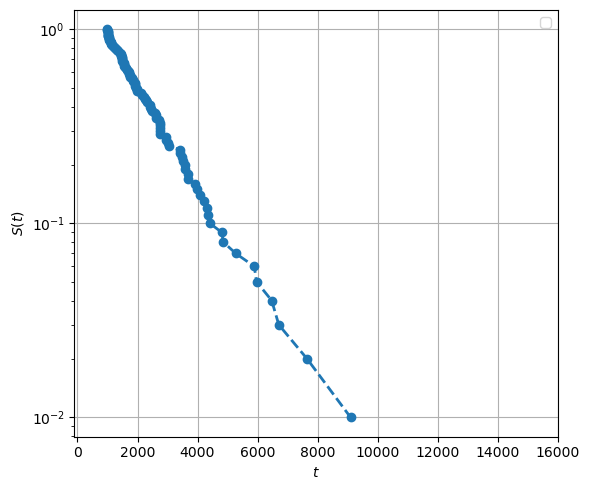

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for re_i in range(len(data['Truth']['re_values'])):
    re = data['Truth']['re_values'][re_i]
    relam_times_truth = build_relaminarisation_times_from_tasks(res, data['Truth']['tasks'][re_i])
    expon_law_t_0, expon_law_tau = expon.fit(np.array(relam_times_truth, dtype=float))
    expon_law_fits['Truth'][re] = {'t_0': expon_law_t_0, 'tau': expon_law_tau}
    lines = ax.semilogy(*survival_function(relam_times_truth), 'o--', color=colors['dark'][re_i], linewidth=2);
    if re not in data['ESN']['re_values']:
        lines_for_legend.append(lines[0])
        re_for_legend.append(re)

ax.grid()
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$S(t)$')
ax.set_xlim((-100, 16000))
lines_and_re_sorted = sorted(zip(lines_for_legend, re_for_legend), key=itemgetter(1))
lines_for_legend = [pair[0] for pair in lines_and_re_sorted]
labes_for_legend = [r'$Re = ' + str(pair[1]) + r'$' for pair in lines_and_re_sorted]
ax.legend(lines_for_legend, labes_for_legend)
plt.tight_layout()
plt.show()

In [9]:
for re_i in range(len(data['Truth']['re_values'])):
    re = data['Truth']['re_values'][re_i]
    if re in data['ESN']['re_values']:
        relam_times_esn = build_relaminarisation_times_from_tasks(res, data['ESN']['tasks'][re_i - 1])
        expon_law_t_0, expon_law_tau = expon.fit(np.array(relam_times_esn, dtype=float))
        expon_law_fits['ESN'][re] = {'t_0': expon_law_t_0, 'tau': expon_law_tau}
        lines = ax.semilogy(*survival_function(relam_times_esn), '^--', color=colors['dark'][re_i], linewidth=2);
        lines_for_legend.append(lines[0])
        re_for_legend.append(re)

In [10]:
for re in expon_law_fits['ESN'].keys():
    print(f'Re = {re}, Truth exponential law parameters: t_0 = {expon_law_fits["Truth"][re]["t_0"]}, '
          f'tau = {expon_law_fits["Truth"][re]["tau"]}')
    print(f'Re = {re}, ESN exponential law parameters: t_0 = {expon_law_fits["ESN"][re]["t_0"]}, '
          f'tau = {expon_law_fits["ESN"][re]["tau"]}, '
          f'Relative error in tau: {np.abs(expon_law_fits["ESN"][re]["tau"] - expon_law_fits["Truth"][re]["tau"]) / np.abs(expon_law_fits["Truth"][re]["tau"])}')
    expon_law_fits['ESN'][re]

Re = 275, Truth exponential law parameters: t_0 = 985.0, tau = 1502.37
Re = 275, ESN exponential law parameters: t_0 = 985.0, tau = 1502.37, Relative error in tau: 0.0


In [17]:
t = {
    42: 'Esn',
    #46:'Esn train min len',
    #47:'Esn train max len',
    #48:'Esn train 1954 len',
    #49:'Esn train max len-10_000',
    #50:'Esn train max len unuse bias',
    51:'Esn train 1954 len-10_000',
    52:'Esn train 1954 len-10_000 unuse bias',
}

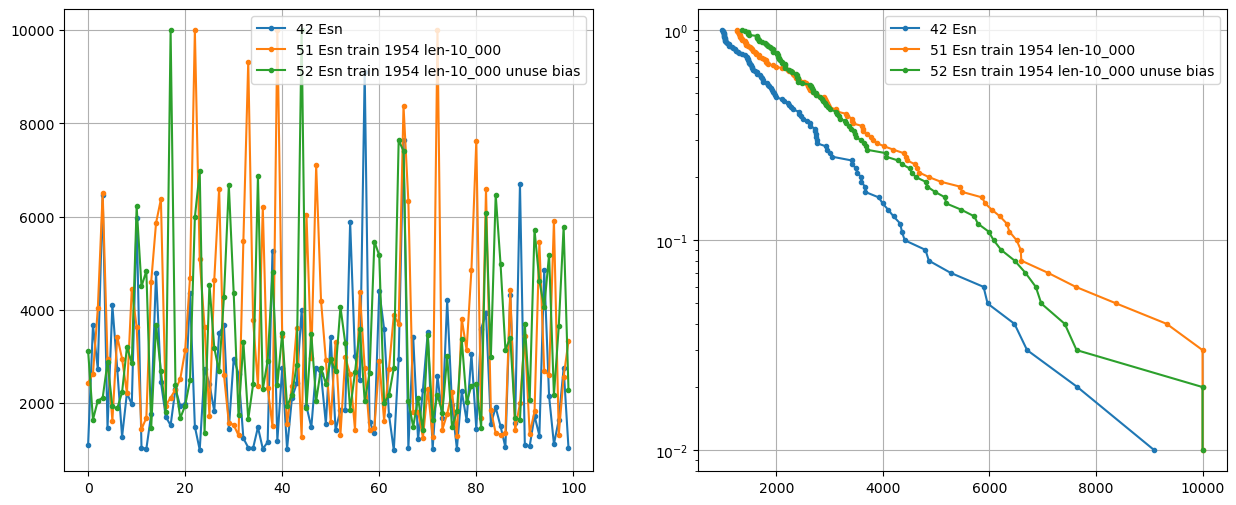

In [18]:
plt.figure(figsize=(15,6))
a = [build_relaminarisation_times_from_tasks(res, [i]) for i in t.keys()]

plt.subplot(1,2,1)
for i, j, k in zip(a, t.keys(), t.values()):
    plt.plot(i, '.-', label=str(j)+' '+k)

plt.grid()
plt.legend()

plt.subplot(1,2,2)
for i, j, k in zip(a, t.keys(), t.values()):
    plt.plot(*survival_function(i), '.-', label=str(j)+' '+k)
plt.semilogy()
plt.grid()
plt.legend()


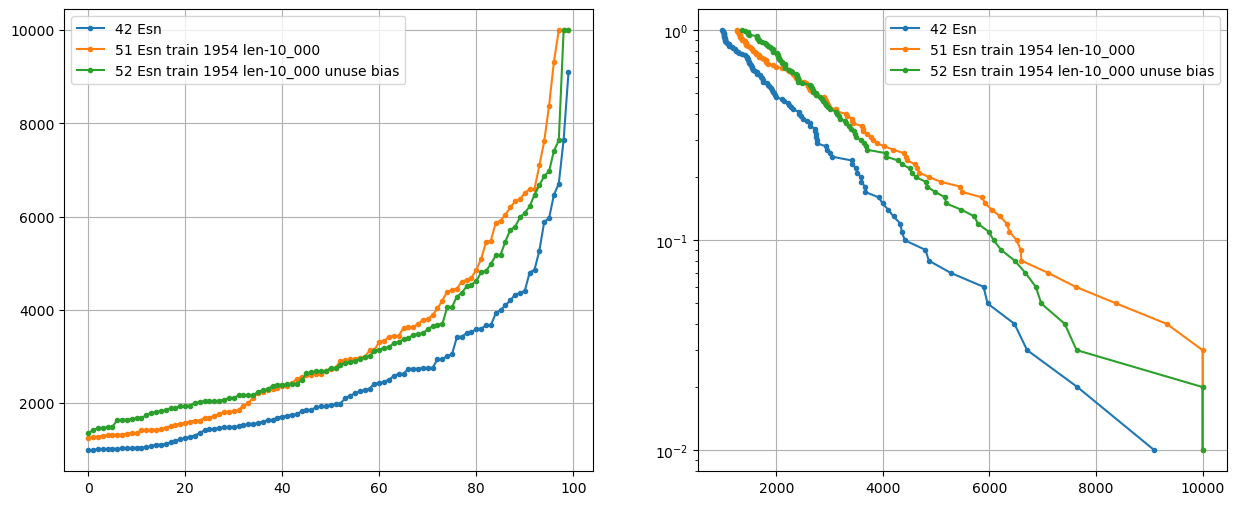

In [19]:
plt.figure(figsize=(15,6))
a = [build_relaminarisation_times_from_tasks(res, [i]) for i in t.keys()]

plt.subplot(1,2,1)
for i, j, k in zip(a, t.keys(), t.values()):
    plt.plot(np.sort(i), '.-', label=str(j)+' '+k)

plt.grid()
plt.legend()

plt.subplot(1,2,2)
for i, j, k in zip(a, t.keys(), t.values()):
    plt.plot(*survival_function(i), '.-', label=str(j)+' '+k)
plt.semilogy()
plt.grid()
plt.legend()
